In [1]:
# Númericas
import numpy as np         # Para trabajar arreglos matriciales
import random              # Para determinar valores aleatorios
import scipy.stats as ss   # Aleatoriedad atada a una distribución de probabilidad
import pandas as pd
import math 

# Gráficas
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

# Importamos la clase de Regresión Lineal de scikit-learn
from sklearn.linear_model import LinearRegression 
# para generar características polinómicas
from sklearn.preprocessing import PolynomialFeatures 

# Strong market


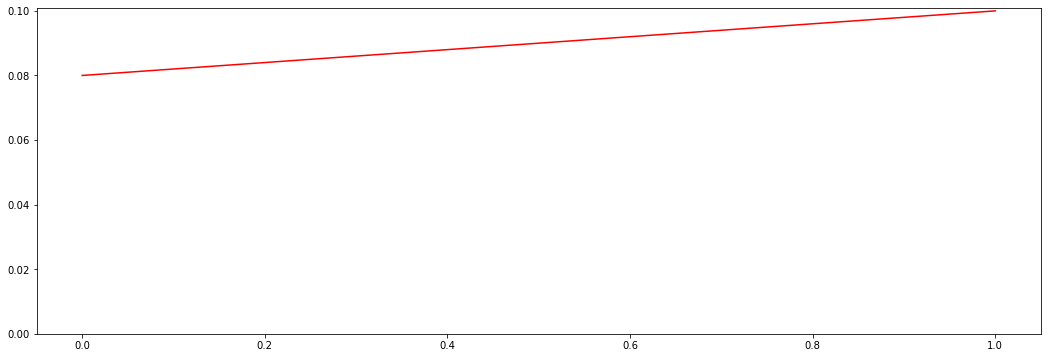

In [2]:
# Valores que puede tomar la tasa de utilización
utilizationRate = np.linspace(0+1e-18,1,100)  # 100.000 puntos

baseBorrowRate = 0.08  # Tasa base de cobro
slope = 0.02  # Incremento en las tasas de interés

# Curva de intereses (mercado fuerte --> ETH, BTC, etc.)
def getBorrowAPR_strongMarket(utilizationRate,baseBorrowRate,slope):
    """
    Interest model for volatile markets
    """
    return baseBorrowRate + slope*utilizationRate

borrowRate_SM = []
for rate in utilizationRate:
    borrowRate_SM.append(getBorrowAPR_strongMarket(rate,baseBorrowRate,slope))
    
figsize(18,6)
plt.plot(utilizationRate,borrowRate_SM,c="r")
plt.ylim(bottom=0)
plt.show()

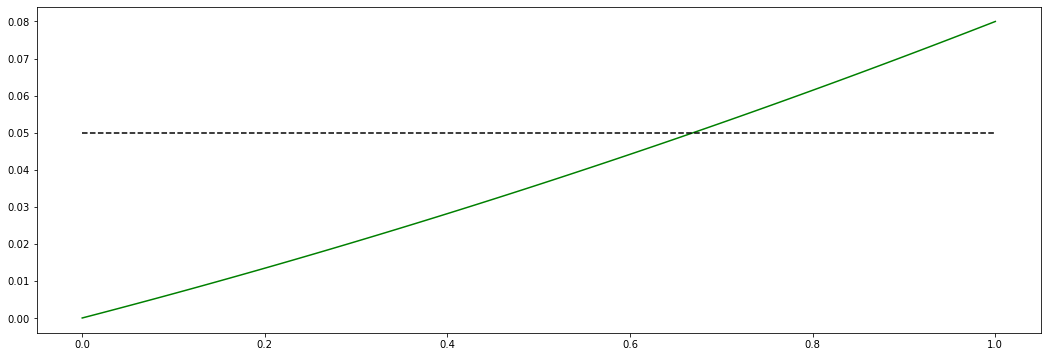

In [3]:
# Porcentaje de los intereses cobrados que se va para el fondo de reservas 
reserveFactor = 0.2

def compoundSupplyRate(utilizationRate,borrowRate,reserveFactor):
    return utilizationRate*borrowRate*(1 - reserveFactor)

compoundSupplyRate_SM = []
expected = []
for r in range(len(utilizationRate)):
    compoundSupplyRate_SM.append(compoundSupplyRate(utilizationRate[r],borrowRate_SM[r],reserveFactor))
    expected.append(0.05)
    
plt.plot(utilizationRate,compoundSupplyRate_SM,c="g")
plt.plot(utilizationRate,expected,"k--")
plt.show()

Estableceremos los multiplicadores que nos servirán para distribuir parte de los intereses

In [4]:
# Procentaje de los intereses que pagan los borrowers que no se van para reservas
freeInterest = []

for rate in borrowRate_SM:
    freeInterest.append(rate*(1-reserveFactor))

# Para encontrar el multiplicador que nos garantice el 5% de rendimiento realizamos el siguiente calculo:
multipliers = []

# Calculo de los multiplicadores basandose en el modelo de Compound
for i in range(len(freeInterest)):
    multipliers.append(max(1,0.05/(freeInterest[i]*utilizationRate[i])))

# Ahora calcularemos el supply rate
supplyRateWithMultipliers = []

for r in range(len(freeInterest)):
    supplyRateWithMultipliers.append(freeInterest[r]*multipliers[r]*utilizationRate[r])

# Nos interesará que el protocolo siempre genere ganancias, para ver esto calcularemos el margen generado
# por los multiplicadores
margen = []

for r in range(len(borrowRate_SM)):
    margen.append(borrowRate_SM[r] - supplyRateWithMultipliers[r])

Debemos ser capaces de describir la distribución de intereses para nuestros suppliers, para esto será necesario generar una función que describa esto de manera continua, para ello realizaremos una regresión polinomica cuyo grado dependerá de los parámetros iniciales del modelo.

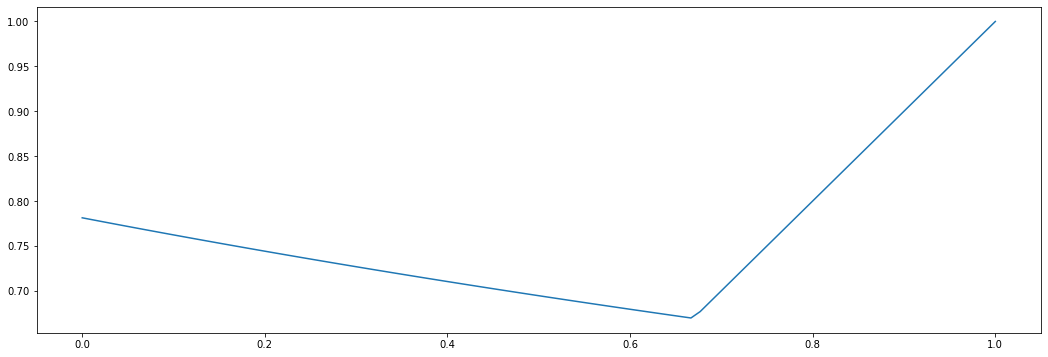

In [5]:
# Ahora trataremos de encontrar una función que nos garantice un 5% de rendimiento, para esto consideraremos
functionValues = []

# Valores a los cuales debemos acercarnos con nuestra función
for r in range(len(utilizationRate)):
    functionValues.append(utilizationRate[r]*multipliers[r])
    
plt.plot(utilizationRate,functionValues)
plt.show()

A continuación realizaremos algunas regresiones lineales 

In [6]:
def regression(grade,functionValues):
    """Realiza la regresion polinomial de un grado dado"""
    # Usaremos polinomios de grado n
    pf = PolynomialFeatures(degree = grade)
    # --------------------------------------------------------
    utilizationRate = np.linspace(0,1,len(functionValues)) 
    X = pf.fit_transform(utilizationRate.reshape(-1,1)) 
    # creamos una instancia de LinearRegression
    instance = LinearRegression()
    # vemos los parámetros que ha estimado la regresión lineal
    instance.fit(X, functionValues) 
    return instance

regresion = regression(5,functionValues)
value = str(regresion.intercept_)
for c in range(len(regresion.coef_[1:])):
    if c == 0:
        value += "+"+str(regresion.coef_[1:][0])+"X"
    else:
        value += "+"+str(regresion.coef_[1:][c])+"X**"+str((c+1))

print("La expresión es:", value)

La expresión es: 0.79430382653128+-0.7535134152320737X+5.0314482908643905X**2+-15.961713748818154X**3+20.229509452842407X**4+-8.344272531527647X**5


In [7]:
def tropykusUtilizationModel(utilizationRate,regresion):
    """
    Modelo de tasas de utilización aplicando la regresión
    """
    a = regresion.intercept_
    coefficients = regresion.coef_[1:]
    value = a
    for c in range(len(coefficients)):
        value += coefficients[c]*utilizationRate**(c+1)
    return value

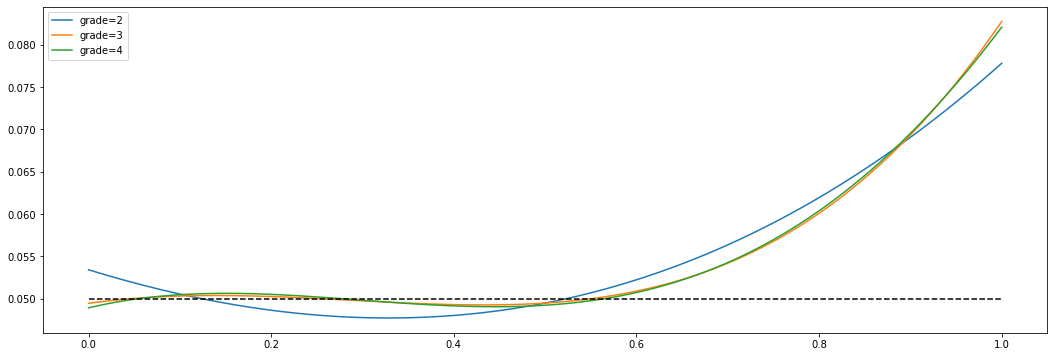

In [8]:
baseBorrowRate = 0.08
slope = 0.02
reserveFactor = 0.2

grades = [2,3,4]
regressions = []
utilizationRate = np.linspace(0,1,100)  # 100 puntos para el ejercicio
borrowRate = []
for rate in utilizationRate:
    borrowRate.append(getBorrowAPR_strongMarket(rate,baseBorrowRate,slope))

for grade in grades:
    regressions.append(regression(grade,functionValues))

utilizationsRate = []
for regresion in regressions:
    data = []
    for rate in utilizationRate:
        data.append(tropykusUtilizationModel(rate,regresion))
    utilizationsRate.append(data)
    
supplysRate = []
for data in utilizationsRate:
    supplyRate = []
    for r in range(len(data)):
        supplyRate.append(data[r]*borrowRate[r]*(1 - reserveFactor))
    supplysRate.append(supplyRate)

for d in range(len(supplysRate)):
    plt.plot(utilizationRate,supplysRate[d],label="grade="+str(grades[d]))
plt.plot(utilizationRate,expected,"k--")
plt.legend()
plt.show()

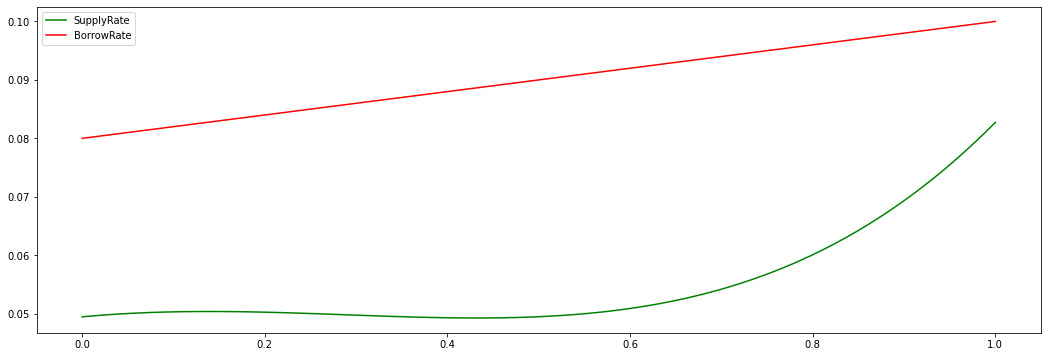

In [9]:
# Modelo de tasas de interés para activos fuertes en Tropykus
plt.plot(utilizationRate,supplysRate[1],c="g",label="SupplyRate")
plt.plot(utilizationRate,borrowRate,c="r",label="BorrowRate")
# plt.ylim(bottom = 0)
plt.legend()
plt.show()

# Stable markets

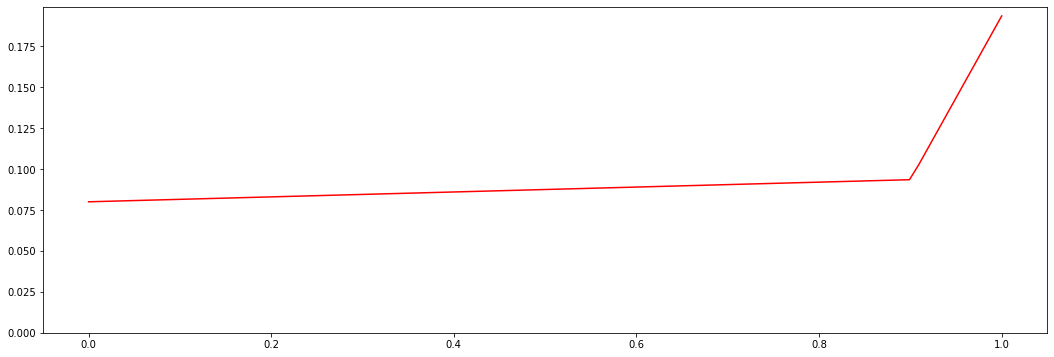

In [10]:
# Valores que puede tomar la tasa de utilización
utilizationRate = np.linspace(0+1e-18,1,100)  # 100.000 puntos

baseBorrowRate = 0.08  # Tasa base de cobro
optimalUtilizationRate = 0.9
slope1 = 0.015  # Incremento en las tasas de interés para una utilización menor a la optima
slope2 = 1  # Incremento en las tasas de interés para una utilización mayor a la optima

def getBorrowAPR_stableMartet(utilizationRate,baseBorrowRate,slope1,slope2,optimalUtilizationRate):
    """
    Interest model for "stable" markets
    """
    if utilizationRate <= optimalUtilizationRate:
        return baseBorrowRate+slope1*utilizationRate
    else:
        return (baseBorrowRate + (slope1 - slope2)*optimalUtilizationRate) + slope2*utilizationRate
    
borrowRate_stable = []
for rate in utilizationRate:
    borrowRate_stable.append(getBorrowAPR_stableMartet(rate,baseBorrowRate,slope1,slope2,optimalUtilizationRate))
    
figsize(18,6)
plt.plot(utilizationRate,borrowRate_stable,c="r")
plt.ylim(bottom=0)
plt.show()

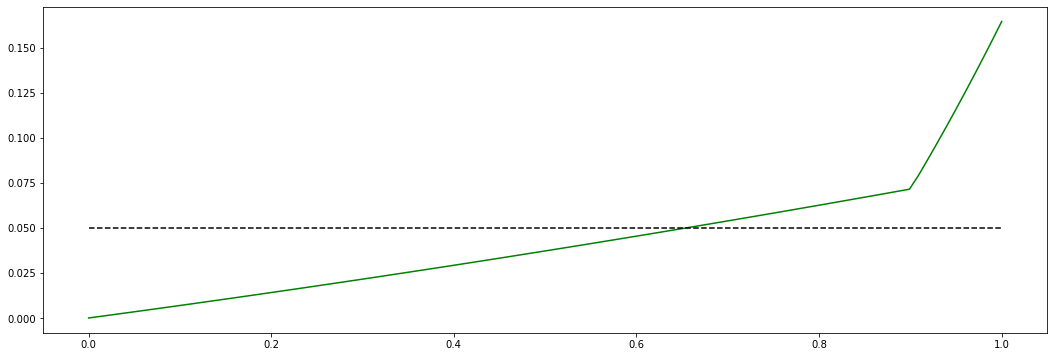

In [11]:
reserveFactor = 0.15

compoundSupplyRate_stable = []
expected = []
for r in range(len(utilizationRate)):
    compoundSupplyRate_stable.append(compoundSupplyRate(utilizationRate[r],borrowRate_stable[r],reserveFactor))
    expected.append(0.05)
    
plt.plot(utilizationRate,compoundSupplyRate_stable,c="g")
plt.plot(utilizationRate,expected,"k--")
plt.show()

In [12]:
# Procentaje de los intereses que pagan los borrowers que no se van para reservas
freeInterest = []

for rate in borrowRate_stable:
    freeInterest.append(rate*(1-reserveFactor))

# Para encontrar el multiplicador que nos garantice el 5% de rendimiento realizamos el siguiente calculo:
multipliers = []

# Calculo de los multiplicadores basandose en el modelo de Compound
for i in range(len(freeInterest)):
    multipliers.append(max(1,0.05/(freeInterest[i]*utilizationRate[i])))

# Ahora calcularemos el supply rate
supplyRateWithMultipliers = []

for r in range(len(freeInterest)):
    supplyRateWithMultipliers.append(freeInterest[r]*multipliers[r]*utilizationRate[r])

# Nos interesará que el protocolo siempre genere ganancias, para ver esto calcularemos el margen generado
# por los multiplicadores
margen = []

for r in range(len(borrowRate_stable)):
    margen.append(borrowRate_stable[r] - supplyRateWithMultipliers[r])

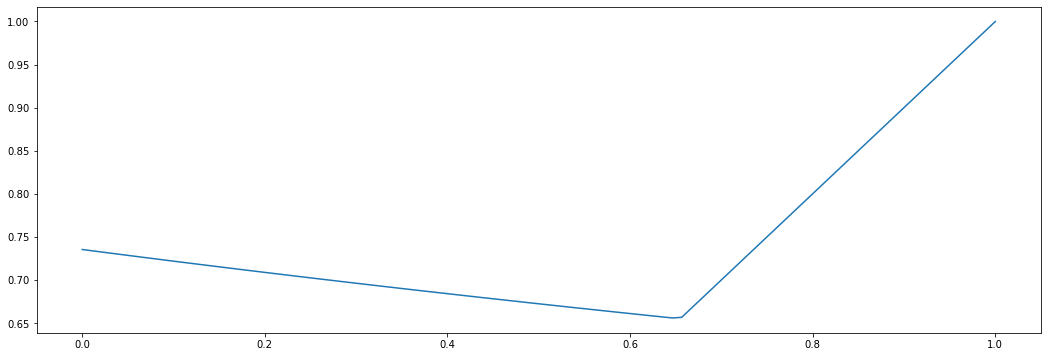

In [13]:
# Ahora trataremos de encontrar una función que nos garantice un 5% de rendimiento, para esto consideraremos
functionValues = []

# Valores a los cuales debemos acercarnos con nuestra función
for r in range(len(utilizationRate)):
    functionValues.append(utilizationRate[r]*multipliers[r])
    
plt.plot(utilizationRate,functionValues)
plt.show()

In [14]:
regresion = regression(4,functionValues)
value = str(regresion.intercept_)
for c in range(len(regresion.coef_[1:])):
    if c == 0:
        value += "+"+str(regresion.coef_[1:][0])+"X"
    else:
        value += "+"+str(regresion.coef_[1:][c])+"X**"+str((c+1))

print("La expresión es:", value)

La expresión es: 0.7168780417274577+0.31924831087549305X+-2.201284269852895X**2+3.1895195103055736X**3+-1.0019670759226667X**4


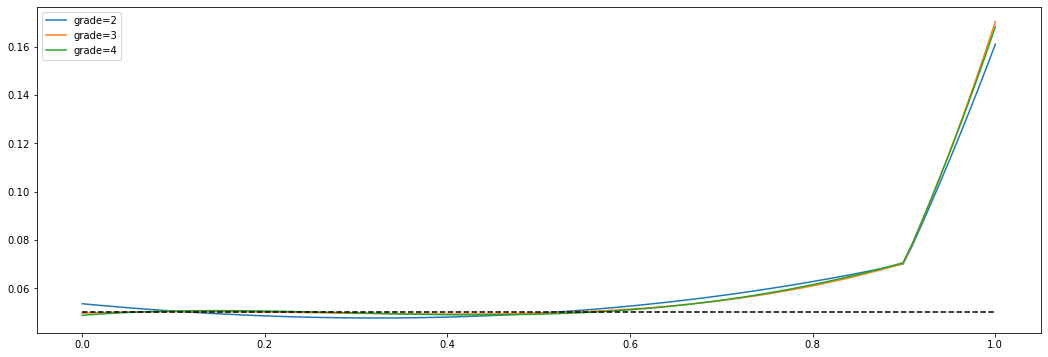

In [15]:
grades = [2,3,4]
regressions = []

for grade in grades:
    regressions.append(regression(grade,functionValues))

utilizationsRate = []
for regresion in regressions:
    data = []
    for rate in utilizationRate:
        data.append(tropykusUtilizationModel(rate,regresion))
    utilizationsRate.append(data)
    
supplysRate = []
for data in utilizationsRate:
    supplyRate = []
    for r in range(len(data)):
        supplyRate.append(data[r]*borrowRate_stable[r]*(1 - reserveFactor))
    supplysRate.append(supplyRate)

for d in range(len(supplysRate)):
    plt.plot(utilizationRate,supplysRate[d],label="grade="+str(grades[d]))
plt.plot(utilizationRate,expected,"k--")
plt.legend()
plt.show()

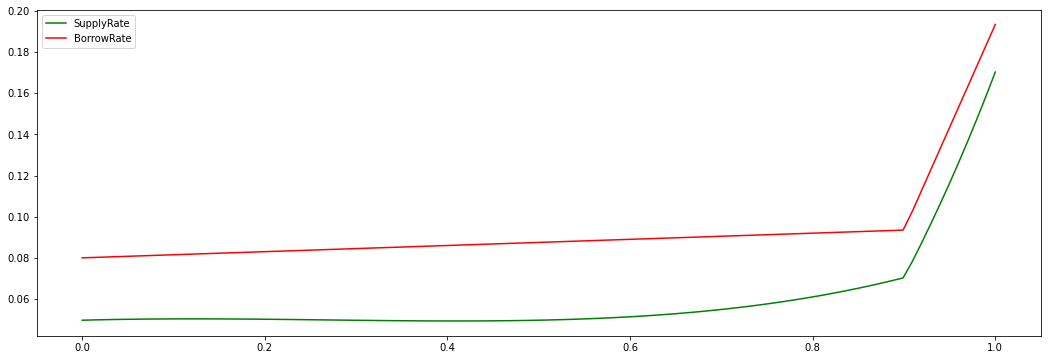

In [16]:
# Modelo de tasas de interés para activos fuertes en Tropykus
plt.plot(utilizationRate,supplysRate[1],c="g",label="SupplyRate")
plt.plot(utilizationRate,borrowRate_stable,c="r",label="BorrowRate")
# plt.ylim(bottom = 0)
plt.legend()
plt.show()